In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Veriyi düzgün şekilde yüklemek için ';' ile ayrılmış olduğunu belirteceğiz
data = pd.read_csv('demetevler.csv', sep=';')

# Sütun isimlerini düzenleyelim
data.columns = ['date', 'PM10', 'PM2.5', 'NO2']

# Tarih sütununu datetime formatına çevirelim
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [3]:
data.head()

,date,PM10,PM2.5,NO2
0,2015-01-01,"18,95","24,75","35,97"
1,2015-01-02,"21,28","24,75","25,52"
2,2015-01-03,"41,91","26,08","31,11"
3,2015-01-04,"32,45","18,39","27,37"
4,2015-01-05,"18,8","24,75","25,26"


In [4]:
data['PM10'] = data['PM10'].str.replace(',', '.').astype(float)
data['PM2.5'] = data['PM2.5'].str.replace(',', '.').astype(float)
data['NO2'] = data['NO2'].str.replace(',', '.').astype(float)

In [5]:
data.set_index('date', inplace=True)

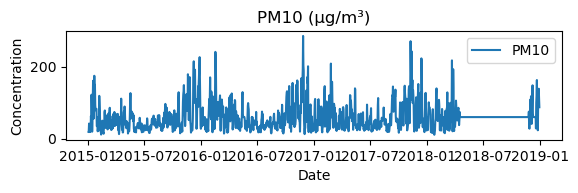

In [6]:
plt.subplot(3, 1, 1)
plt.plot(data.index, data['PM10'], label='PM10')
plt.title('PM10 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

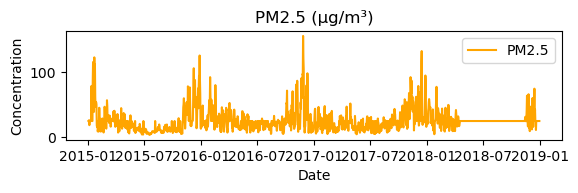

In [7]:
plt.subplot(3, 1, 2)
plt.plot(data.index, data['PM2.5'], label='PM2.5', color='orange')
plt.title('PM2.5 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

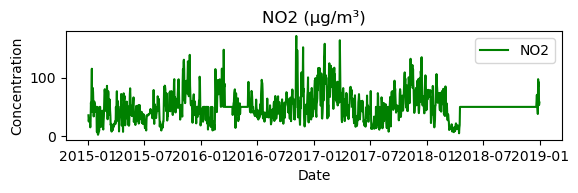

In [8]:
plt.subplot(3, 1, 3)
plt.plot(data.index, data['NO2'], label='NO2', color='green')
plt.title('NO2 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

In [9]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.")

In [10]:
# PM10 için ADF Testi
adf_test(data['PM10'], title='PM10')

Augmented Dickey-Fuller Test: PM10
ADF Test Statistic            -6.205778e+00
p-value                        5.662649e-08
#Lags Used                     1.400000e+01
Number of Observations Used    1.446000e+03
Critical Value (1%)           -3.434880e+00
Critical Value (5%)           -2.863541e+00
Critical Value (10%)          -2.567835e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [11]:
# PM2.5 için ADF Testi
adf_test(data['PM2.5'], title='PM2.5')

Augmented Dickey-Fuller Test: PM2.5
ADF Test Statistic               -5.286837
p-value                           0.000006
#Lags Used                       12.000000
Number of Observations Used    1448.000000
Critical Value (1%)              -3.434874
Critical Value (5%)              -2.863538
Critical Value (10%)             -2.567834
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [12]:
# NO2 için ADF Testi
adf_test(data['NO2'], title='NO2')

Augmented Dickey-Fuller Test: NO2
ADF Test Statistic               -4.983614
p-value                           0.000024
#Lags Used                       14.000000
Number of Observations Used    1446.000000
Critical Value (1%)              -3.434880
Critical Value (5%)              -2.863541
Critical Value (10%)             -2.567835
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [13]:
def plot_acf_pacf(series, lags=50):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    # ACF grafiği
    plot_acf(series, lags=lags, ax=ax[0])
    ax[0].set_title('ACF')

    # PACF grafiği
    plot_pacf(series, lags=lags, ax=ax[1])
    ax[1].set_title('PACF')

    plt.show()

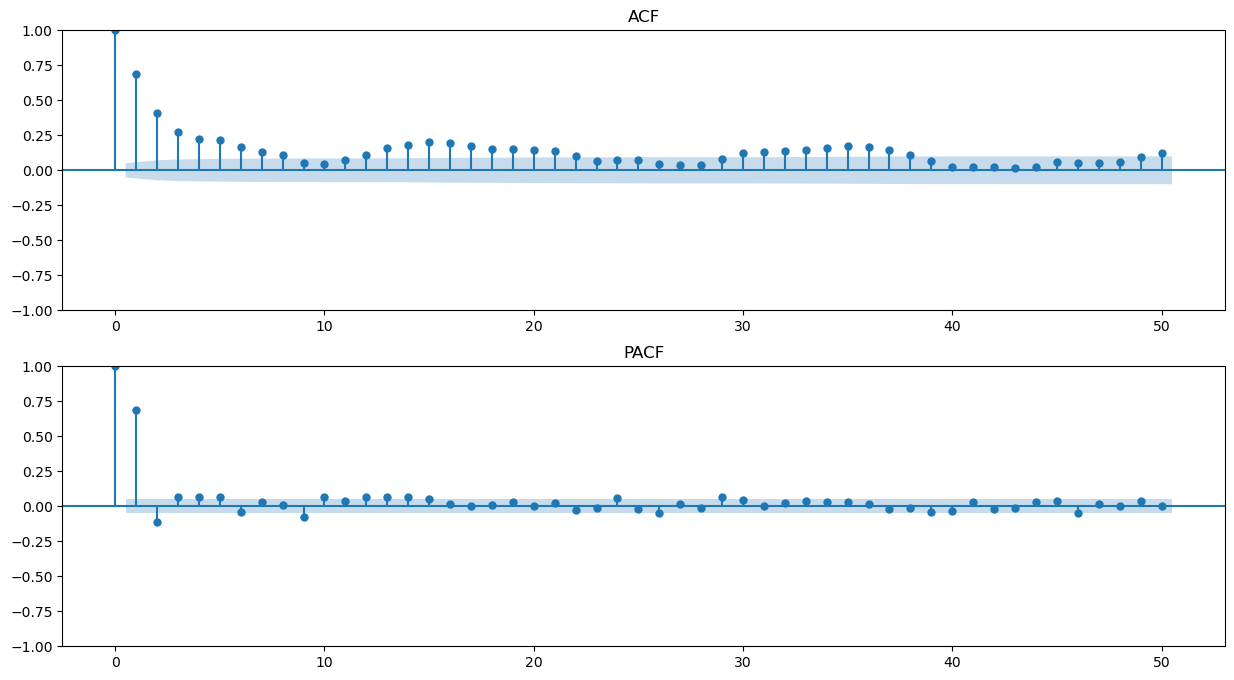

In [14]:
plot_acf_pacf(data['PM10'].dropna())

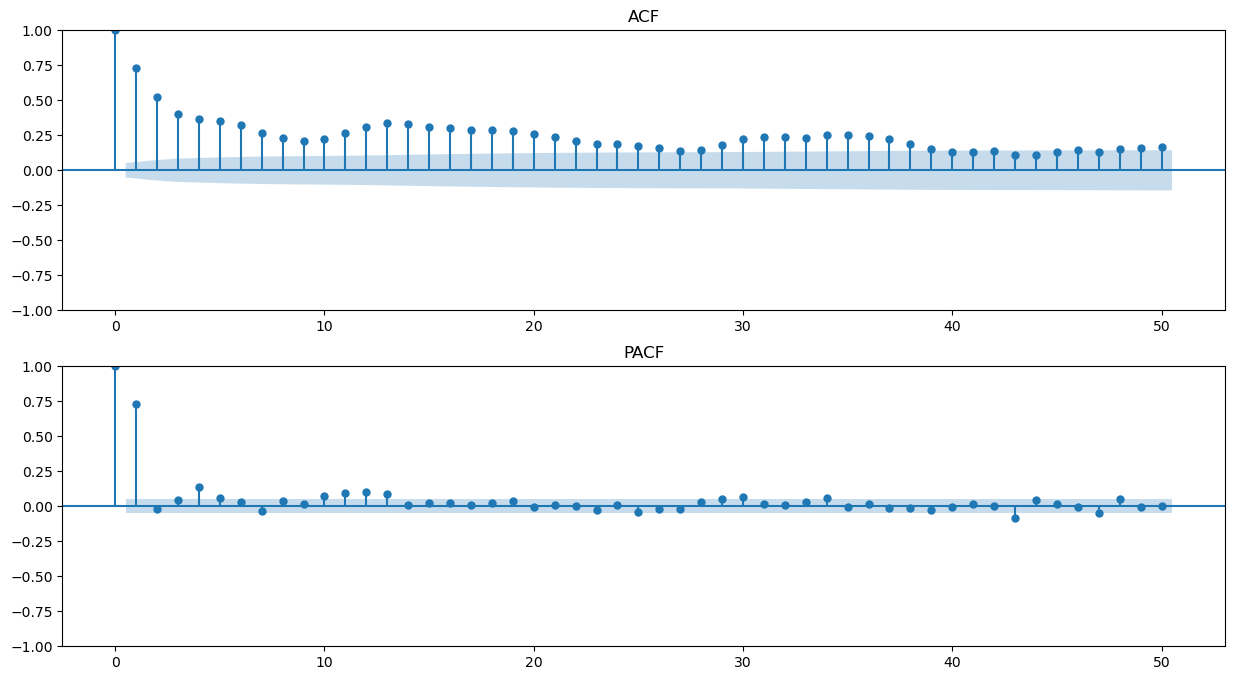

In [15]:
plot_acf_pacf(data['PM2.5'].dropna())

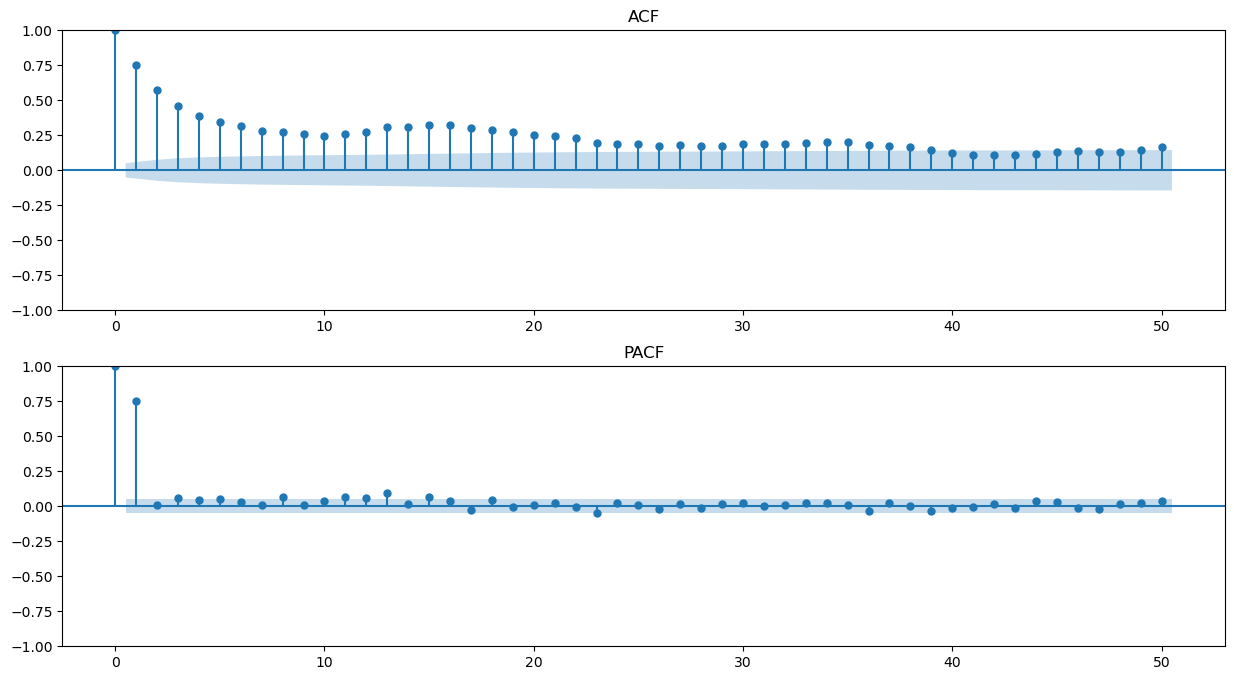

In [16]:
# NO2 için ACF ve PACF grafikleri
plot_acf_pacf(data['NO2'].dropna())

In [17]:
## PM10 İÇİN BEST MODEL BULMA VE PERFORMANS ÖLÇME







In [18]:
def evaluate_arima_model(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fitPM10 = model.fit()
    aic = model_fitPM10.aic
    bic = model_fitPM10.bic
    return aic, bic

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_model(data['PM10'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=14651.507 BIC=14662.080
ARIMA(0, 0, 1) AIC=13935.204 BIC=13951.065
ARIMA(0, 0, 2) AIC=13781.067 BIC=13802.215
ARIMA(0, 0, 3) AIC=13730.502 BIC=13756.936
ARIMA(0, 0, 4) AIC=13730.163 BIC=13761.884
ARIMA(0, 1, 0) AIC=13965.719 BIC=13971.005
ARIMA(0, 1, 1) AIC=13956.192 BIC=13966.764
ARIMA(0, 1, 2) AIC=13792.962 BIC=13808.821
ARIMA(0, 1, 3) AIC=13713.582 BIC=13734.727
ARIMA(0, 1, 4) AIC=13690.588 BIC=13717.019
ARIMA(0, 2, 0) AIC=15058.595 BIC=15063.880
ARIMA(0, 2, 1) AIC=13966.572 BIC=13977.143
ARIMA(0, 2, 2) AIC=13957.197 BIC=13973.054
ARIMA(0, 2, 3) AIC=13796.547 BIC=13817.689
ARIMA(0, 2, 4) AIC=13718.870 BIC=13745.298
ARIMA(1, 0, 0) AIC=13729.311 BIC=13745.172
ARIMA(1, 0, 1) AIC=13710.190 BIC=13731.337
ARIMA(1, 0, 2) AIC=13710.007 BIC=13736.441
ARIMA(1, 0, 3) AIC=13705.008 BIC=13736.729
ARIMA(1, 0, 4) AIC=13691.618 BIC=13728.626
ARIMA(1, 1, 0) AIC=13961.725 BIC=13972.298
ARIMA(1, 1, 1) AIC=13718.440 BIC=13734.298
ARIMA(1, 1, 2) AIC=13689.351 BIC=13710.496
ARIMA(1, 1,

In [20]:
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train = data[:train_size]
val = data[train_size:train_size+val_size]
test = data[train_size+val_size:]

In [21]:
model = ARIMA(train['PM10'], order=(3, 1, 4))
model_fitPM10 = model.fit()

In [22]:
val_predictions = model_fitPM10.forecast(steps=len(val))
val_predictions = pd.Series(val_predictions, index=val.index)

if val['PM10'].isnull().values.any():
    val['PM10'] = val['PM10'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictions.isnull().values.any():
    val_predictions = val_predictions.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_val = mean_absolute_error(val['PM10'], val_predictions)
mse_val = mean_squared_error(val['PM10'], val_predictions)
rmse_val = np.sqrt(mse_val)

print(f'Validation MAE: {mae_val}')
print(f'Validation MSE: {mse_val}')
print(f'Validation RMSE: {rmse_val}')

Validation MAE: 30.321786279672605
Validation MSE: 1734.105122207013
Validation RMSE: 41.64258784234012


In [23]:
# Test seti üzerinde tahmin yapma
test_predictions = model_fitPM10.forecast(steps=len(test))
test_predictions = pd.Series(test_predictions, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['PM10'].isnull().values.any():
    test['PM10'] = test['PM10'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictions.isnull().values.any():
    test_predictions = test_predictions.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_test = mean_absolute_error(test['PM10'], test_predictions)
mse_test = mean_squared_error(test['PM10'], test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

Test MAE: 9.141166457835185
Test MSE: 436.1311286534737
Test RMSE: 20.883752743543813


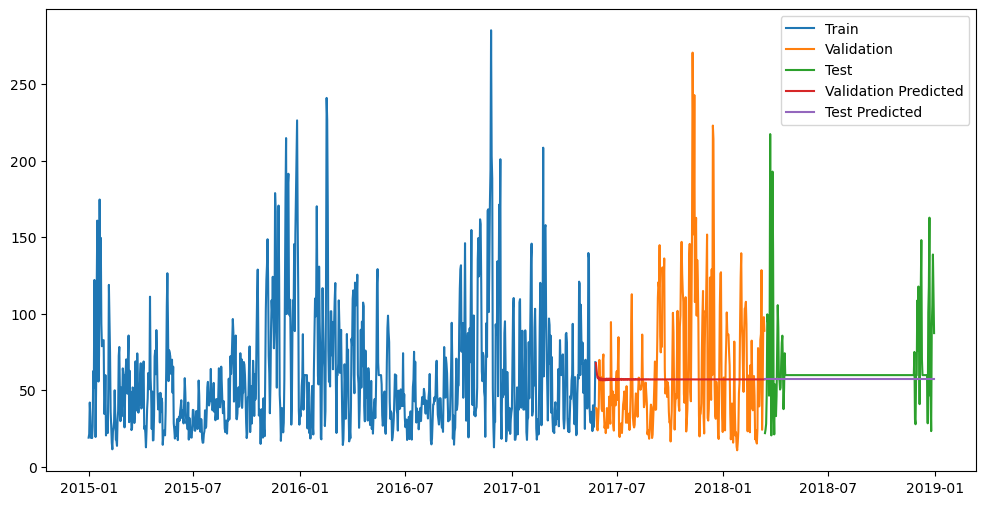

In [24]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['PM10'], label='Train')
plt.plot(val['PM10'], label='Validation')
plt.plot(test['PM10'], label='Test')
plt.plot(val_predictions, label='Validation Predicted')
plt.plot(test_predictions, label='Test Predicted')
plt.legend()
plt.show()

In [25]:
best_modelPM10 = ARIMA(data['PM10'], order=(3, 1, 4))
model_fitPM10 = best_modelPM10.fit()

print(model_fitPM10.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1461
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -6831.534
Date:                Tue, 11 Jun 2024   AIC                          13679.068
Time:                        15:53:16   BIC                          13721.358
Sample:                    01-01-2015   HQIC                         13694.844
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7741      0.046    -16.889      0.000      -0.864      -0.684
ar.L2         -0.3223      0.044     -7.371      0.000      -0.408      -0.237
ar.L3          0.4075      0.040     10.068      0.0

In [26]:
n_periods = 4  # 4 adım ileriye tahmin
forecast = model_fitPM10.forecast(steps=n_periods)
forecast

2019-01-01    78.641057
2019-01-02    75.404471
2019-01-03    75.461859
2019-01-04    74.116558
Freq: D, Name: predicted_mean, dtype: float64

In [27]:
# Güven aralıklarını hesaplama
conf_int = model_fitPM10.get_forecast(steps=n_periods).conf_int()

In [28]:
# Tahminleri DataFrame'e çevirme
forecast_index = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=forecast_index)

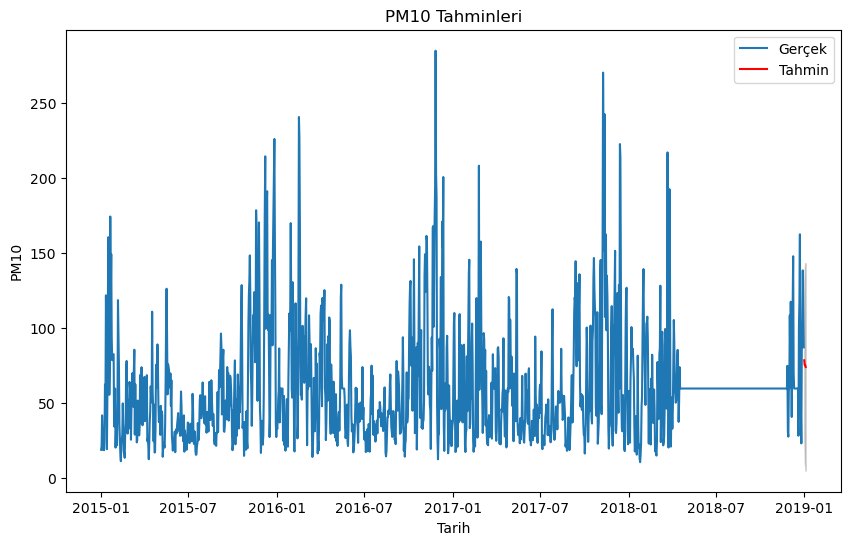

In [29]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['PM10'], label='Gerçek')
plt.plot(forecast_series.index, forecast_series, color='red', label='Tahmin')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('PM10')
plt.title('PM10 Tahminleri')
plt.legend()
plt.show()

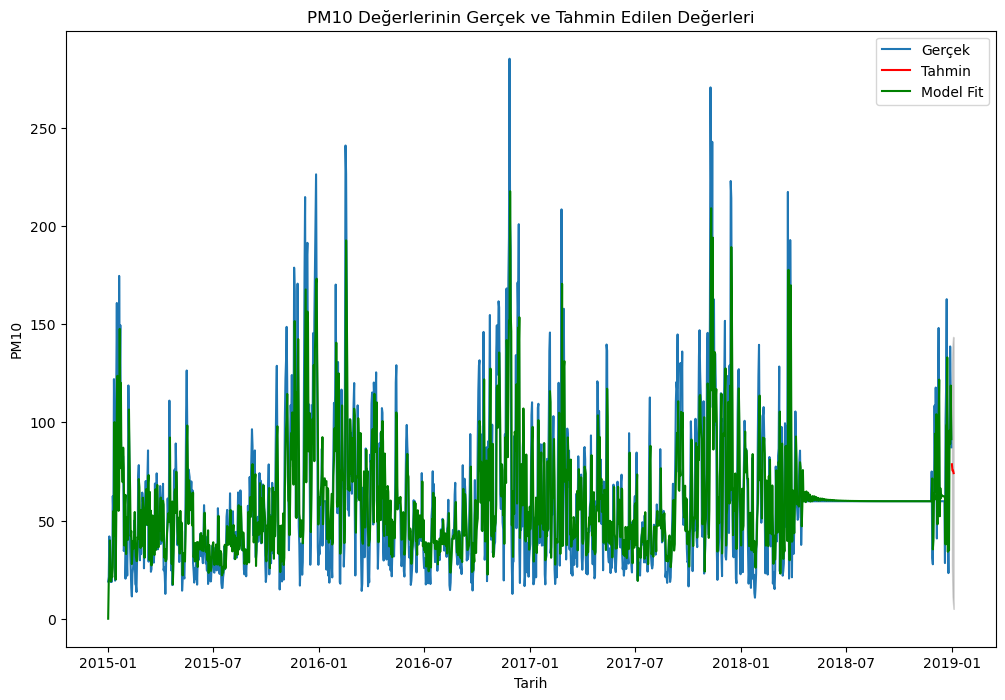

In [30]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['PM10'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_series.index, forecast_series, color='red', label='Tahmin')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_values = model_fitPM10.fittedvalues
plt.plot(fitted_values.index, fitted_values, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('PM10')
plt.title('PM10 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()

In [31]:
# PM2.5 İÇİN TÜM İLERLEMELER  





In [32]:
def evaluate_arima_modelPM25(data, arima_order):
    modelPM25 = ARIMA(data, order=arima_order)
    model_fitPM25 = modelPM25.fit()
    aic = model_fitPM25.aic
    bic = model_fitPM25.bic
    return aic, bic

p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 3)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_modelPM25(data['PM2.5'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=12479.126 BIC=12489.700
ARIMA(0, 0, 1) AIC=11757.532 BIC=11773.393
ARIMA(0, 0, 2) AIC=11497.729 BIC=11518.877
ARIMA(0, 1, 0) AIC=11566.812 BIC=11572.098
ARIMA(0, 1, 1) AIC=11534.309 BIC=11544.882
ARIMA(0, 1, 2) AIC=11425.133 BIC=11440.992
ARIMA(0, 2, 0) AIC=12735.968 BIC=12741.254
ARIMA(0, 2, 1) AIC=11569.192 BIC=11579.763
ARIMA(0, 2, 2) AIC=11537.182 BIC=11553.039
ARIMA(0, 3, 0) AIC=14318.093 BIC=14323.378
ARIMA(0, 3, 1) AIC=12737.542 BIC=12748.111
ARIMA(0, 3, 2) AIC=11587.071 BIC=11602.926
ARIMA(1, 0, 0) AIC=11367.104 BIC=11382.965
ARIMA(1, 0, 1) AIC=11368.598 BIC=11389.745
ARIMA(1, 0, 2) AIC=11365.768 BIC=11392.203
ARIMA(1, 1, 0) AIC=11547.805 BIC=11558.378
ARIMA(1, 1, 1) AIC=11329.087 BIC=11344.946
ARIMA(1, 1, 2) AIC=11321.493 BIC=11342.638
ARIMA(1, 2, 0) AIC=12341.797 BIC=12352.368
ARIMA(1, 2, 1) AIC=11550.525 BIC=11566.382
ARIMA(1, 2, 2) AIC=11566.045 BIC=11587.187
ARIMA(1, 3, 0) AIC=13474.129 BIC=13484.699
ARIMA(1, 3, 1) AIC=12344.457 BIC=12360.311
ARIMA(1, 3,

In [33]:
modelPM25 = ARIMA(train['PM2.5'], order=(3, 1, 2))
model_fitPM25 = modelPM25.fit()

In [34]:
val_predictionsPM25 = model_fitPM25.forecast(steps=len(val))
val_predictionsPM25 = pd.Series(val_predictionsPM25, index=val.index)

if val['PM2.5'].isnull().values.any():
    val['PM2.5'] = val['PM2.5'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictionsPM25.isnull().values.any():
    val_predictionsPM25 = val_predictionsPM25.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_valPM25 = mean_absolute_error(val['PM2.5'], val_predictionsPM25)
mse_valPM25 = mean_squared_error(val['PM2.5'], val_predictionsPM25)
rmse_valPM25 = np.sqrt(mse_valPM25)

print(f'Validation MAE: {mae_valPM25}')
print(f'Validation MSE: {mse_valPM25}')
print(f'Validation RMSE: {rmse_valPM25}')

Validation MAE: 14.234261561728788
Validation MSE: 490.7456770021634
Validation RMSE: 22.152780344736943


In [35]:
# Test seti üzerinde tahmin yapma
test_predictionsPM25 = model_fitPM25.forecast(steps=len(test))
test_predictionsPM25 = pd.Series(test_predictionsPM25, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['PM2.5'].isnull().values.any():
    test['PM2.5'] = test['PM2.5'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictionsPM25.isnull().values.any():
    test_predictionsPM25 = test_predictionsPM25.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_testPM25 = mean_absolute_error(test['PM2.5'], test_predictionsPM25)
mse_testPM25 = mean_squared_error(test['PM2.5'], test_predictionsPM25)
rmse_testPM25 = np.sqrt(mse_testPM25)

print(f'Test MAE: {mae_testPM25}')
print(f'Test MSE: {mse_testPM25}')
print(f'Test RMSE: {rmse_testPM25}')

Test MAE: 8.805363981441765
Test MSE: 114.51842553882499
Test RMSE: 10.701328213769774


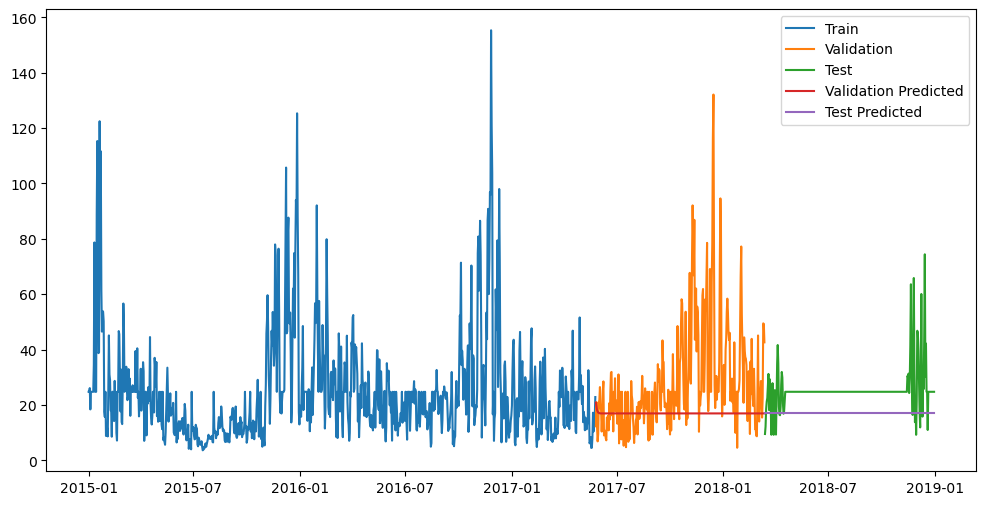

In [36]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['PM2.5'], label='Train')
plt.plot(val['PM2.5'], label='Validation')
plt.plot(test['PM2.5'], label='Test')
plt.plot(val_predictionsPM25, label='Validation Predicted')
plt.plot(test_predictionsPM25, label='Test Predicted')
plt.legend()
plt.show()

In [37]:
best_modePM25 = ARIMA(data['PM2.5'], order=(3, 1, 2))
model_fitPM25 = best_modePM25.fit()
print(model_fitPM25.summary())      #BURADA OVERFİTTİNG DURUMU OLDUĞU İÇİN EN İYİ MODEL SEÇİMİ DEĞİŞİYOR

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1461
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5652.732
Date:                Tue, 11 Jun 2024   AIC                          11317.465
Time:                        15:54:03   BIC                          11349.182
Sample:                    01-01-2015   HQIC                         11329.297
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1107      0.104     -1.060      0.289      -0.315       0.094
ar.L2          0.4437      0.069      6.392      0.000       0.308       0.580
ar.L3         -0.1145      0.018     -6.481      0.0

In [38]:
n_periods = 12  # 4 adım ileriye tahmin
forecastPM25 = model_fitPM25.forecast(steps=n_periods)
forecastPM25

2019-01-01    25.959194
2019-01-02    27.070756
2019-01-03    27.484219
2019-01-04    27.793245
2019-01-05    27.815242
2019-01-06    27.902599
2019-01-07    27.867309
2019-01-08    27.907463
2019-01-09    27.877356
2019-01-10    27.902548
2019-01-11    27.881802
2019-01-12    27.898724
Freq: D, Name: predicted_mean, dtype: float64

In [39]:
# Güven aralıklarını hesaplama
conf_intPM25 = model_fitPM25.get_forecast(steps=n_periods).conf_int()

In [40]:
# Tahminleri DataFrame'e çevirme
forecast_indexPM25 = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_seriesPM25 = pd.Series(forecastPM25, index=forecast_indexPM25)
lower_seriesPM25 = pd.Series(conf_intPM25.iloc[:, 0], index=forecast_indexPM25)
upper_seriesPM25 = pd.Series(conf_intPM25.iloc[:, 1], index=forecast_indexPM25)

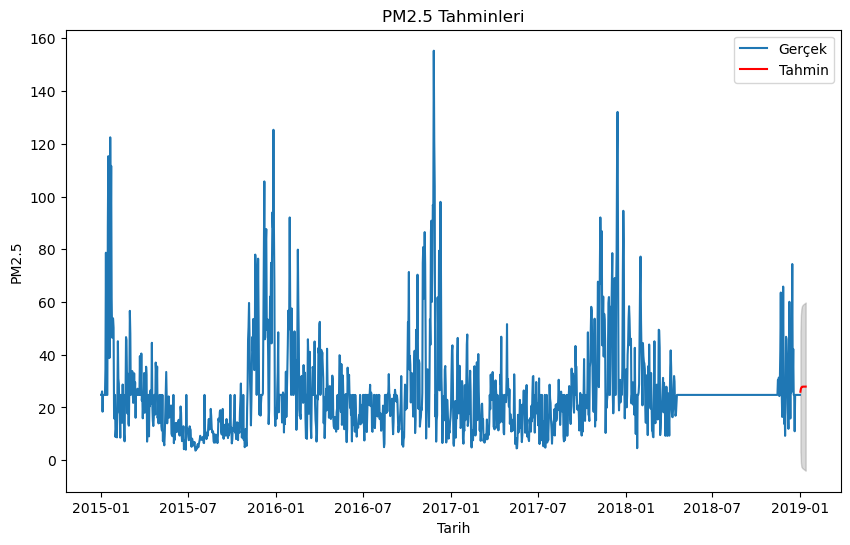

In [41]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['PM2.5'], label='Gerçek')
plt.plot(forecast_seriesPM25.index, forecast_seriesPM25, color='red', label='Tahmin')
plt.fill_between(lower_seriesPM25.index, 
                 lower_seriesPM25, 
                 upper_seriesPM25, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('PM2.5')
plt.title('PM2.5 Tahminleri')
plt.legend()
plt.show()

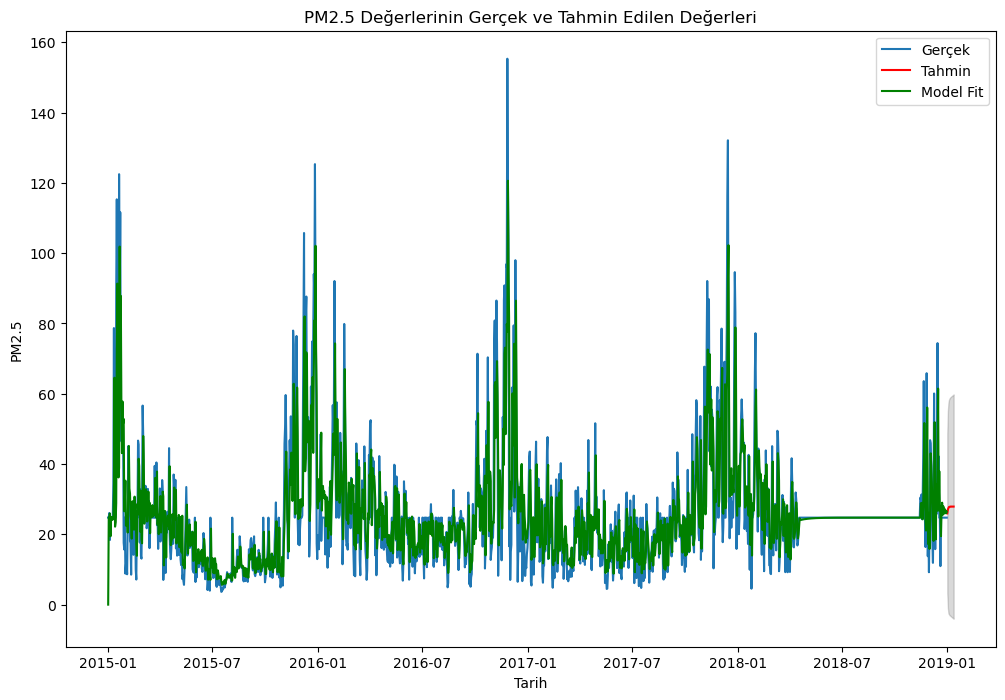

In [42]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['PM2.5'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_seriesPM25.index, forecast_seriesPM25, color='red', label='Tahmin')
plt.fill_between(lower_seriesPM25.index, lower_seriesPM25, upper_seriesPM25, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_valuesPM25 = model_fitPM25.fittedvalues
plt.plot(fitted_valuesPM25.index, fitted_valuesPM25, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('PM2.5')
plt.title('PM2.5 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()

In [43]:
# NO2 İÇİN TÜM İLERLEMELER  








In [44]:
def evaluate_arima_modelNO2(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fitNO2 = model.fit()
    aic = model_fitNO2.aic
    bic = model_fitNO2.bic
    return aic, bic

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_modelNO2(data['NO2'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=13464.260 BIC=13474.834
ARIMA(0, 0, 1) AIC=12680.454 BIC=12696.315
ARIMA(0, 0, 2) AIC=12442.790 BIC=12463.938
ARIMA(0, 0, 3) AIC=12341.676 BIC=12368.111
ARIMA(0, 0, 4) AIC=12303.941 BIC=12335.662
ARIMA(0, 1, 0) AIC=12412.194 BIC=12417.480
ARIMA(0, 1, 1) AIC=12375.441 BIC=12386.013
ARIMA(0, 1, 2) AIC=12297.186 BIC=12313.044
ARIMA(0, 1, 3) AIC=12240.697 BIC=12261.841
ARIMA(0, 1, 4) AIC=12214.341 BIC=12240.772
ARIMA(0, 2, 0) AIC=13594.404 BIC=13599.689
ARIMA(0, 2, 1) AIC=12413.984 BIC=12424.555
ARIMA(0, 2, 2) AIC=12377.716 BIC=12393.572
ARIMA(0, 2, 3) AIC=12300.710 BIC=12321.852
ARIMA(0, 2, 4) AIC=12245.624 BIC=12272.051
ARIMA(1, 0, 0) AIC=12233.879 BIC=12249.740
ARIMA(1, 0, 1) AIC=12235.747 BIC=12256.894
ARIMA(1, 0, 2) AIC=12229.808 BIC=12256.243
ARIMA(1, 0, 3) AIC=12224.927 BIC=12256.648
ARIMA(1, 0, 4) AIC=12211.125 BIC=12248.133
ARIMA(1, 1, 0) AIC=12389.231 BIC=12399.803
ARIMA(1, 1, 1) AIC=12202.808 BIC=12218.666
ARIMA(1, 1, 2) AIC=12201.142 BIC=12222.287
ARIMA(1, 1,

In [45]:
model = ARIMA(train['NO2'], order=(1, 1, 2))
model_fitNO2 = model.fit()

In [46]:
val_predictionsNO2 = model_fitNO2.forecast(steps=len(val))
val_predictionsNO2 = pd.Series(val_predictionsNO2, index=val.index)

if val['NO2'].isnull().values.any():
    val['NO2'] = val['NO2'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictionsNO2.isnull().values.any():
    val_predictionsNO2 = val_predictionsNO2.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_valNO2 = mean_absolute_error(val['NO2'], val_predictionsNO2)
mse_valNO2 = mean_squared_error(val['NO2'], val_predictionsNO2)
rmse_valNO2 = np.sqrt(mse_valNO2)

print(f'Validation MAE: {mae_valNO2}')
print(f'Validation MSE: {mse_valNO2}')
print(f'Validation RMSE: {rmse_valNO2}')

Validation MAE: 20.035296042194666
Validation MSE: 662.5034784172086
Validation RMSE: 25.739142923127968


In [47]:
# Test seti üzerinde tahmin yapma
test_predictionsNO2 = model_fitNO2.forecast(steps=len(test))
test_predictionsNO2 = pd.Series(test_predictionsNO2, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['NO2'].isnull().values.any():
    test['NO2'] = test['NO2'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictionsNO2.isnull().values.any():
    test_predictionsNO2 = test_predictionsNO2.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_testNO2 = mean_absolute_error(test['NO2'], test_predictionsNO2)
mse_testNO2 = mean_squared_error(test['NO2'], test_predictionsNO2)
rmse_testNO2 = np.sqrt(mse_testNO2)

print(f'Test MAE: {mae_testNO2}')
print(f'Test MSE: {mse_testNO2}')
print(f'Test RMSE: {rmse_testNO2}')

Test MAE: 5.590875323022282
Test MSE: 182.99716142897267
Test RMSE: 13.527644341457705


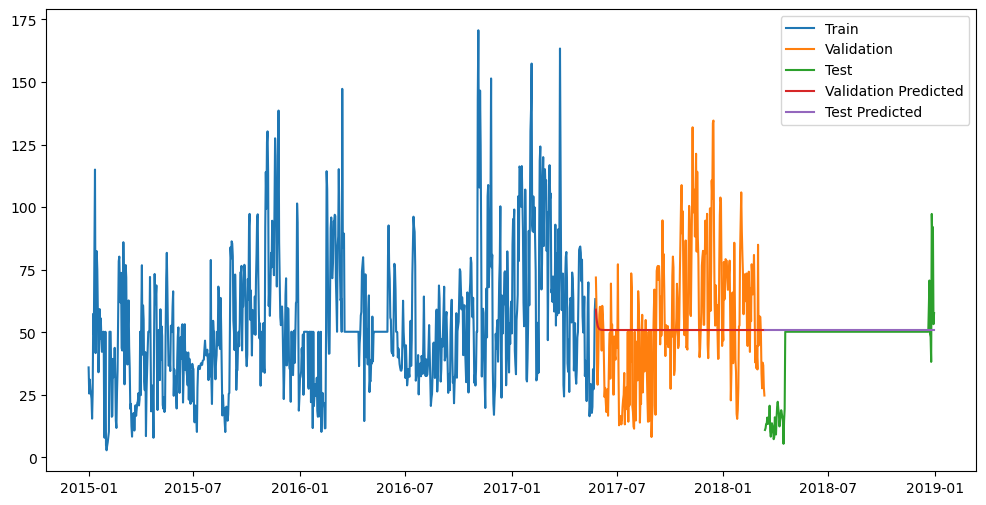

In [48]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['NO2'], label='Train')
plt.plot(val['NO2'], label='Validation')
plt.plot(test['NO2'], label='Test')
plt.plot(val_predictionsNO2, label='Validation Predicted')
plt.plot(test_predictionsNO2, label='Test Predicted')
plt.legend()
plt.show()

In [49]:
best_modelNO2 = ARIMA(data['NO2'], order=(1, 1, 2))
model_fitNO2 = best_modelNO2.fit()
print(model_fitNO2.summary())  

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1461
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6096.571
Date:                Tue, 11 Jun 2024   AIC                          12201.142
Time:                        15:55:28   BIC                          12222.287
Sample:                    01-01-2015   HQIC                         12209.030
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6009      0.034     17.618      0.000       0.534       0.668
ma.L1         -0.8692      0.037    -23.624      0.000      -0.941      -0.797
ma.L2         -0.0768      0.031     -2.510      0.0

In [50]:
n_periods = 12  # 4 adım ileriye tahmin
forecastNO2 = model_fitNO2.forecast(steps=n_periods)
forecastNO2

2019-01-01    57.707842
2019-01-02    57.292338
2019-01-03    57.042681
2019-01-04    56.892674
2019-01-05    56.802542
2019-01-06    56.748386
2019-01-07    56.715846
2019-01-08    56.696294
2019-01-09    56.684547
2019-01-10    56.677488
2019-01-11    56.673247
2019-01-12    56.670698
Freq: D, Name: predicted_mean, dtype: float64

In [51]:
# Güven aralıklarını hesaplama
conf_intNO2 = model_fitNO2.get_forecast(steps=n_periods).conf_int()

In [52]:
# Tahminleri DataFrame'e çevirme
forecast_indexNO2 = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_seriesNO2 = pd.Series(forecastNO2, index=forecast_indexNO2)
lower_seriesNO2 = pd.Series(conf_intNO2.iloc[:, 0], index=forecast_indexNO2)
upper_seriesNO2 = pd.Series(conf_intNO2.iloc[:, 1], index=forecast_indexNO2)

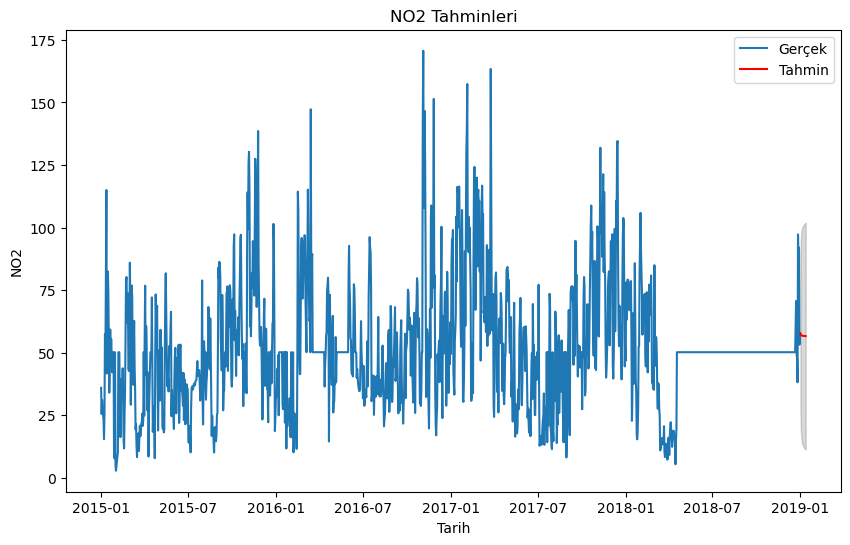

In [53]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['NO2'], label='Gerçek')
plt.plot(forecast_seriesNO2.index, forecast_seriesNO2, color='red', label='Tahmin')
plt.fill_between(lower_seriesNO2.index, 
                 lower_seriesNO2, 
                 upper_seriesNO2, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('NO2')
plt.title('NO2 Tahminleri')
plt.legend()
plt.show()

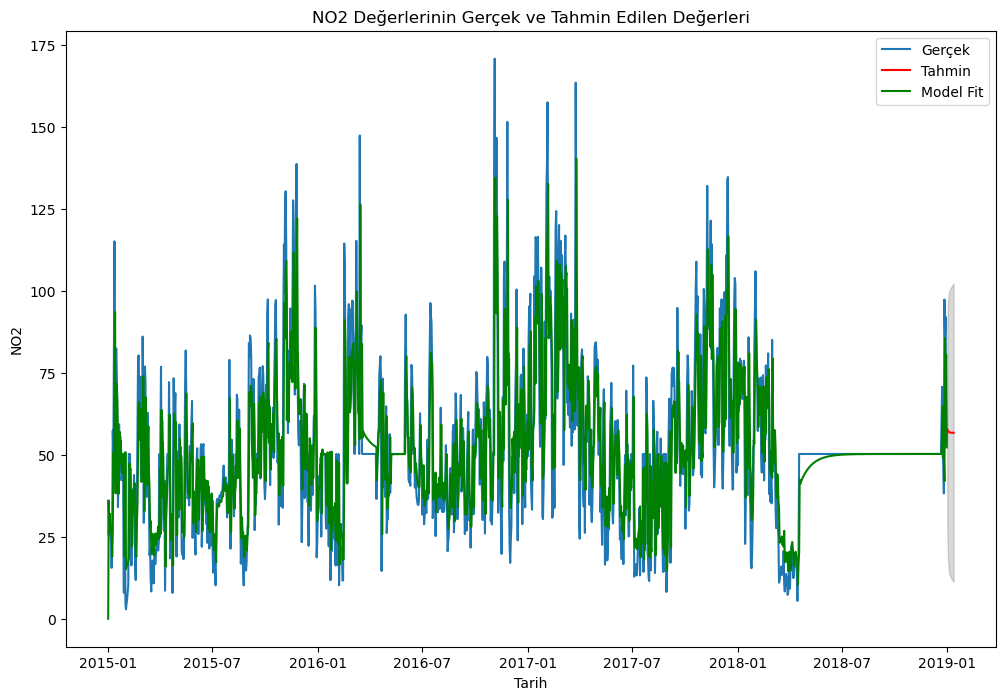

In [54]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['NO2'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_seriesNO2.index, forecast_seriesNO2, color='red', label='Tahmin')
plt.fill_between(lower_seriesNO2.index, lower_seriesNO2, upper_seriesNO2, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_valuesNO2 = model_fitNO2.fittedvalues
plt.plot(fitted_valuesNO2.index, fitted_valuesNO2, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('NO2')
plt.title('NO2 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()